# The Sentiment Analysin on an example of 1600000 tweets

# Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

import tensorflow as tf 
from tensorflow.compat import v1
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB

from wordcloud import WordCloud

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package wordnet to /home/jakub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jakub/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
config = v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = v1.Session(config=config)

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.test.is_built_with_cuda()

True

# Introduction

Sentiment analysis is a domain of natural language processing, the purpose of this process is to classify the message based on the emotions the author felt while writing/talking. It is usually performed on textual data.

# Data
The dataset comes from Kaggle.  
https://www.kaggle.com/kazanova/sentiment140

The dataset contains 1 600 000 tweets with positive or negative sentiment classification, the number of positive and negative messages is equal. There are six columns in the dataset but for text mining, we will use only two of them:
- text - the text of the tweet
- target - 0 for negative and 4 for positive

In [5]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = df[['target','text']]

It is more convenient to mark positive sentiment as number 1 instead of 4.

In [6]:
# set positive as 1
df.loc[df['target']==4, 'target'] = 1
df.loc[df['target']==0, 'target'] = 0

df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Now we can look closer at our data, check if there are any missing values and if the type of columns is correct. 
As we can see the types of columns are correct.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


There is no missing data which means that there is no text without label or label without text.

In [8]:
df.isna().sum()

target    0
text      0
dtype: int64

As we can see the target variable is balanced.

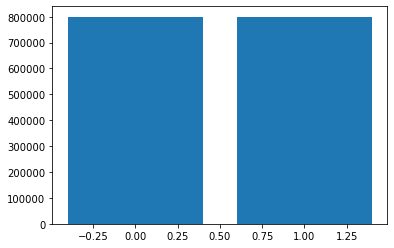

In [9]:
plt.bar(df['target'].value_counts().index, df['target'].value_counts().values)
plt.show()

# Text preprocessing

### Replacing emojis, usernames and groups of many the same letters

Emojis can be easily replaced with words they are meant to symbolize. For this purpose I have created a dictionary of emojis and corresponding words. A lot of emojis correspond to the same emotion, without this dictionary they would be treated as separate words or removed as a combination of punctuation. I supported myself with a list of emojis from Wikipedia: https://en.wikipedia.org/wiki/List_of_emoticons  
  
We can also replace all nicknames with userr and URLs with urlr as they would generate a lot of words without any sensible meaning.  
  
We can also replace words consisting of more than two of the same letters next to each other. There are words with two of the same letters like "cheers" but not with three of them, thanks to this we will avoid treating sets of words like "Heyy", "Heyyy", "Heyyyy" etc. as separate words.  
  
We also make all the letters lowercase and stem them which is further simplification of the text that decreases the number of incorrectly distinguished words.

In [10]:
emojis = {':)': 'happy', ':-)': 'happy', ':D': 'happy', ':-D': 'happy', ':^)':'happy',
         '^^' : 'happy', '^.^':'happy', '^_^':'happy', ':3':'happy', ':-3':'happy', '8)':'happy','8-)':'happy',
          ':]':'happy', ':-]':'happy', '=]':'happy', '=]':'happy','xd':'happy', 'xD':'happy', 'XD':'happy', 
          '=D':'happy', '=3':'happy', ":'‑)":'happy', ":')":'happy', '=^.^=': 'happy',
          
         ';d': 'wink', ';D':'wink', ';)':'wink', ';-)':'wink', ';-)': 'wink', ';‑]':'wink', ';]':'wink',
          
         ':O': 'shocked', ':o': 'shocked', 'D:': 'shocked', ':0':'shocked', ':-O': 'shocked', 
         ':-o': 'shocked', 'D-:': 'shocked', ':-0':'shocked',':-@': 'shocked', ':@': 'shocked',
          
         'O.o': 'confused',':s':'confused', ':S':'confused', ':$':'confused',':-$':'confused', ':-&': 'confused', 
         
         ':P':'playful', ':p':'playful', ';p':'playful', ';P':'playful', '=P':'playful', '=p':'playful',
         ':-P':'playful', ':-p':'playful', ';-p':'playful', ';-P':'playful', '=-P':'playful', '=-p':'playful',
         
         '>:[':'angry', '>:-[':'angry',
          
         ':#': 'mute', ':X': 'mute', 
          
         '<(-_-)>': 'chill', 'd[-_-]b': 'chill',
          
         ':E':'awkward', ':-E': 'awkward',
          
         ':(': 'sad', ':-(': 'sad', ':<':'sad',':-<': 'sad',  ';(':'sad',  ';-(':'sad', ':c':'sad', ':C':'sad',
          ':-c':'sad', ':-C':'sad', ':[':'sad', ':-[':'sad', ":'‑(":'sad', ":'(":'sad', ':/':'sad', ':-/':'sad',
         '=/':'sad','=-/':'sad','=(':'sad', '=[':'sad','=<':'sad', '=-/':'sad','=-(':'sad', '=-[':'sad','=-<':'sad'}

In [11]:
# function that performs all mentioned operations
def replace(tweet):
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Replace all URls with 'urlr'
    tweet = re.sub(urlPattern,'urlr',tweet)

    # Replace all usernames with 'userr'
    tweet = re.sub(userPattern,'userr', tweet)
    
    # replace sequences of the same letters in a single word
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # replacing emojis
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, emojis[emoji])
    
    # lowercase    
    tweet = tweet.lower()
    
    # stemming
    porter = PorterStemmer()
    tweet = porter.stem(tweet)
    
    return tweet

In [12]:
df['text'] = df['text'].apply(replace)

In [13]:
df.head()

,target,text
0,0,"userr urlr - aww, that's a bummer. you should..."
1,0,is upset that he can't update his facebook by ...
2,0,userr i dived many times for the ball. managed...
3,0,my whole body feels itchy and like its on fire
4,0,"userr no, it's not behaving at all. i'm mad. w..."


# Word cloud for negative and positive sentiment

We can create word clouds for positive and negative sentiment, it is nice visualization that tells us which words are the most important for a given category and which are common for both categories. As we can see userr is the most common word for both categories.  
  
Some common words for negative sentiment: sad, work or really.  
Some common words for positive sentiment: thank, good, love.  

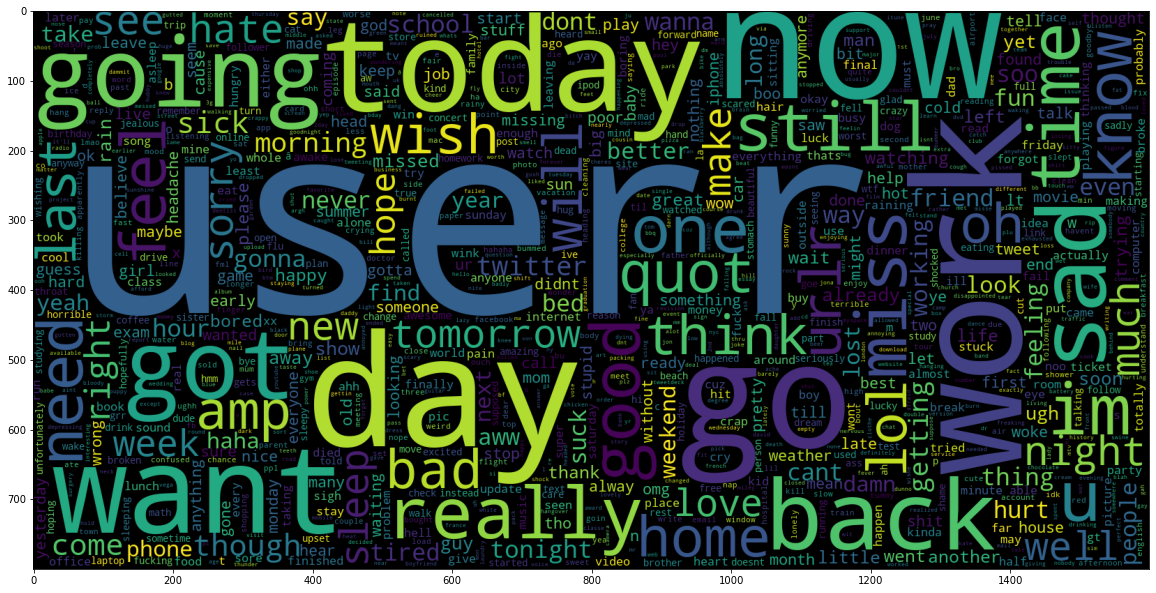

In [14]:
data_neg = df.loc[df['target']==0,'text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

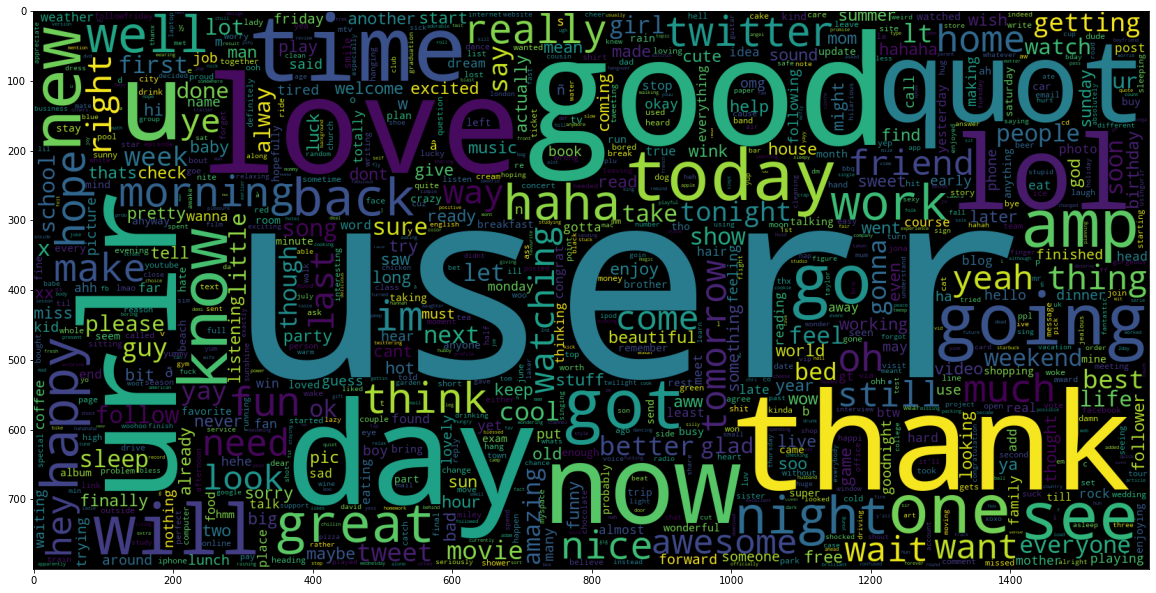

In [15]:
data_neg = df.loc[df['target']==1,'text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# Preparing data for training

Here we perform the train-test split, we will use 30% of the data as test data. Training data will be used for training the model.  

In [16]:
from sklearn.model_selection import train_test_split
X = df["text"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101, train_size = 0.7)
print(len(X_train), len(X_test))

1120000 480000


Thanks to visualization we know that we should use bigrams to catch phrases like "love you" or "thank you" which will simplify our data without losing important information. 
  
For vectorization of the text we use TfidfVectorizer which assigns lower weights to words frequent for both negative and positive sentiment. We set the minimum and maximum document (tweet) frequency to get rid of too frequent or rare words. 

In [17]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 100000,
    ngram_range = (1,2)
)
X_train2 = tfidf.fit_transform(X_train)
X_test2 = tfidf.transform(X_test)

# Selecting the best model

We test the following algorithms from sklearn library:
 - Multinomial naive Bayes
 - Linear support vector machine
 - Logistic regression
 - Ridge regression
 - bernoulli naive Bayes
 - CNN_LSTM
 
We choose the best hyperparameters with help of grid search which also uses 10 fold split for training the models. 

### MultinomialNB

In [18]:
parameters = {'alpha':(0.001,0.01,0.1,1)}
mnb = MultinomialNB()
gs1 = GridSearchCV(mnb, parameters, cv = 10, return_train_score = True)
gs1.fit(X_train2, y_train)

res1 = pd.DataFrame(gs1.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res1['dif'] = res1['mean_train_score'] - res1['mean_test_score']

res1 = res1.sort_values('rank_test_score')
res1.to_csv('res1.csv')
res1

,params,mean_train_score,mean_test_score,rank_test_score,dif
3,{'alpha': 1},0.816887,0.802192,1,0.014695
2,{'alpha': 0.1},0.818213,0.801363,2,0.016850
1,{'alpha': 0.01},0.818409,0.801185,3,0.017224
0,{'alpha': 0.001},0.818447,0.801128,4,0.017319


### LinearSVC

In [19]:
parameters = {'max_iter':(2000,), 'C':(0.001,0.01,0.1,1),'tol':(0.0001,0.001,0.01,0.1)}
svc = LinearSVC()
gs2 = GridSearchCV(svc, parameters, cv = 10, return_train_score = True)
gs2.fit(X_train2, y_train)

res2 = pd.DataFrame(gs2.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res2['dif'] = res2['mean_train_score'] - res2['mean_test_score']

res2 = res2.sort_values('rank_test_score')
res2.to_csv('res2.csv')
res2

,params,mean_train_score,mean_test_score,rank_test_score,dif
11,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.1}",0.843891,0.821894,1,0.021997
9,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.001}",0.843896,0.821861,2,0.022035
10,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.01}",0.843896,0.821860,3,0.022037
8,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.0001}",0.843895,0.821859,4,0.022037
13,"{'C': 1, 'max_iter': 2000, 'tol': 0.001}",0.857858,0.814890,5,0.042968
12,"{'C': 1, 'max_iter': 2000, 'tol': 0.0001}",0.857858,0.814883,6,0.042975
14,"{'C': 1, 'max_iter': 2000, 'tol': 0.01}",0.857852,0.814865,7,0.042987
15,"{'C': 1, 'max_iter': 2000, 'tol': 0.1}",0.857824,0.814810,8,0.043014
7,"{'C': 0.01, 'max_iter': 2000, 'tol': 0.1}",0.815288,0.808667,9,0.006621
4,"{'C': 0.01, 'max_iter': 2000, 'tol': 0.0001}",0.815290,0.808654,10,0.006635


### Logistic regression

In [20]:
parameters = {'max_iter':(2000,), 'C':(0.001,0.01,0.1,1),'tol':(0.0001,0.001,0.01,0.1)}
logr = LogisticRegression()
gs3 = GridSearchCV(logr, parameters, cv = 10, return_train_score = True)
gs3.fit(X_train2, y_train)

res3 = pd.DataFrame(gs3.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res3['dif'] = res3['mean_train_score'] - res3['mean_test_score']

res3 = res3.sort_values('rank_test_score')
res3.to_csv('res3.csv')
res3

,params,mean_train_score,mean_test_score,rank_test_score,dif
12,"{'C': 1, 'max_iter': 2000, 'tol': 0.0001}",0.843311,0.821627,1,0.021684
13,"{'C': 1, 'max_iter': 2000, 'tol': 0.001}",0.843311,0.821627,1,0.021684
14,"{'C': 1, 'max_iter': 2000, 'tol': 0.01}",0.843311,0.821627,1,0.021684
15,"{'C': 1, 'max_iter': 2000, 'tol': 0.1}",0.843311,0.821627,1,0.021684
8,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.0001}",0.814888,0.808262,5,0.006626
9,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.001}",0.814888,0.808262,5,0.006626
10,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.01}",0.814888,0.808262,5,0.006626
11,"{'C': 0.1, 'max_iter': 2000, 'tol': 0.1}",0.814888,0.808262,5,0.006626
4,"{'C': 0.01, 'max_iter': 2000, 'tol': 0.0001}",0.779409,0.777452,9,0.001957
5,"{'C': 0.01, 'max_iter': 2000, 'tol': 0.001}",0.779409,0.777452,9,0.001957


### Ridge

In [21]:
parameters = {'alpha':(0.001,0.01,0.1,1), 'tol':(0.0001,0.001,0.01,0.1)}
ridge = RidgeClassifier()
gs4 = GridSearchCV(ridge, parameters, cv = 10, return_train_score = True)
gs4.fit(X_train2, y_train)

res4 = pd.DataFrame(gs4.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res4['dif'] = res4['mean_train_score'] - res4['mean_test_score']

res4 = res4.sort_values('rank_test_score')
res4.to_csv('res4.csv')
res4

,params,mean_train_score,mean_test_score,rank_test_score,dif
14,"{'alpha': 1, 'tol': 0.01}",0.851750,0.815940,1,0.035809
13,"{'alpha': 1, 'tol': 0.001}",0.852549,0.815670,2,0.036879
12,"{'alpha': 1, 'tol': 0.0001}",0.852565,0.815654,3,0.036912
15,"{'alpha': 1, 'tol': 0.1}",0.824151,0.813684,4,0.010467
3,"{'alpha': 0.001, 'tol': 0.1}",0.824205,0.813563,5,0.010642
7,"{'alpha': 0.01, 'tol': 0.1}",0.824204,0.813561,6,0.010643
11,"{'alpha': 0.1, 'tol': 0.1}",0.824199,0.813561,6,0.010639
10,"{'alpha': 0.1, 'tol': 0.01}",0.853913,0.809716,8,0.044197
8,"{'alpha': 0.1, 'tol': 0.0001}",0.854389,0.808605,9,0.045784
9,"{'alpha': 0.1, 'tol': 0.001}",0.854370,0.808592,10,0.045778


### Bernoulli

In [22]:
parameters = {'alpha':(0.001,0.01,0.1,1)}
ber = BernoulliNB()
gs5 = GridSearchCV(ber, parameters, cv = 10, return_train_score = True)
gs5.fit(X_train2, y_train)

res5 = pd.DataFrame(gs5.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res5['dif'] = res5['mean_train_score'] - res5['mean_test_score']

res5 = res5.sort_values('rank_test_score')
res5.to_csv('res5.csv')
res5

,params,mean_train_score,mean_test_score,rank_test_score,dif
1,{'alpha': 0.01},0.809537,0.796802,1,0.012735
2,{'alpha': 0.1},0.809371,0.796787,2,0.012584
0,{'alpha': 0.001},0.809572,0.796760,3,0.012813
3,{'alpha': 1},0.808373,0.796568,4,0.011805


### CNN-LSTM

In [23]:
max_words_number = 100000

# here we use tokenizer
tokenizer = Tokenizer(num_words=max_words_number, char_level=False)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [24]:
# we check some text data statistics usefull for next steps
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

seq_lens = [len(s) for s in sequences_train]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

Found 241036 unique tokens.
average length: 13.2
max length: 51


In [25]:
max_len = 51

# pad sequences with 0s
sequences_train_pad = pad_sequences(sequences_train, maxlen=max_len)
sequences_test_pad = pad_sequences(sequences_test, maxlen=max_len)

print('Shape of data tensor:', sequences_train_pad.shape)
print('Shape of data test tensor:', sequences_test_pad.shape)

Shape of data tensor: (1120000, 51)
Shape of data test tensor: (480000, 51)


In [26]:
def build_model(conv, lstm, kernel_size, max_words, embedding_dim, max_len):    
    model = tf.keras.models.Sequential()
    
    # embedding layer
    model.add(tf.keras.layers.Embedding(max_words,
                                        embedding_dim,
                                        input_length=max_len,
                                        trainable=True))
    model.add(tf.keras.layers.Dropout(0.5))

    # convolution and max pooling layers
    model.add(tf.keras.layers.Conv1D(conv, kernel_size, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.5))
      
    # LSTM layer
    model.add(tf.keras.layers.LSTM(lstm, dropout = 0.5))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
param_grid = dict(conv=[32, 64],
                  lstm=[32, 64],
                  kernel_size = [3,5],
                  max_words = [100000],
                  embedding_dim = [32],
                  max_len = [51])


model = KerasClassifier(build_fn=build_model, epochs=5, batch_size=128)

gs6 = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, verbose=1,return_train_score=True)

gs6.fit(sequences_train_pad, y_train.values)

res6 = pd.DataFrame(gs6.cv_results_)[['params','mean_train_score','mean_test_score', 'rank_test_score']]
res6['dif'] = res6['mean_train_score'] - res6['mean_test_score']

res6 = res6.sort_values('rank_test_score')
res6.to_csv('res6.csv')
res6

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/5
7000/7000 [==============================] - 124s 18ms/step - loss: 0.4708 - accuracy: 0.7798
Epoch 2/5
7000/7000 [==============================] - 126s 18ms/step - loss: 0.4333 - accuracy: 0.8048
Epoch 3/5
7000/7000 [==============================] - 122s 17ms/step - loss: 0.4216 - accuracy: 0.8108
Epoch 4/5
7000/7000 [==============================] - 118s 17ms/step - loss: 0.4145 - accuracy: 0.8152
Epoch 5/5
7000/7000 [==============================] - 7s 1ms/step - loss: 0.3833 - accuracy: 0.8340
Epoch 1/5
7000/7000 [==============================] - 118s 17ms/step - loss: 0.4712 - accuracy: 0.7791
Epoch 2/5
7000/7000 [==============================] - 119s 17ms/step - loss: 0.4341 - accuracy: 0.8040
Epoch 3/5
7000/7000 [==============================] - 126s 18ms/step - loss: 0.4223 - accuracy: 0.8108
Epoch 4/5
7000/7000 [==============================] - 128s 18ms/step - loss: 0.4150 - accuracy: 0.8147
Epoch 5/5
7000/7000 [==============================] - 8s 1ms/step 

7000/7000 [==============================] - 117s 17ms/step - loss: 0.4266 - accuracy: 0.8077
Epoch 3/5
7000/7000 [==============================] - 117s 17ms/step - loss: 0.4140 - accuracy: 0.8147
Epoch 4/5
7000/7000 [==============================] - 117s 17ms/step - loss: 0.4059 - accuracy: 0.8193
Epoch 5/5
7000/7000 [==============================] - 8s 1ms/step - loss: 0.3617 - accuracy: 0.8402
Epoch 1/5
7000/7000 [==============================] - 117s 17ms/step - loss: 0.4639 - accuracy: 0.7832
Epoch 2/5
7000/7000 [==============================] - 117s 17ms/step - loss: 0.4265 - accuracy: 0.8077
Epoch 3/5
7000/7000 [==============================] - 118s 17ms/step - loss: 0.4137 - accuracy: 0.8145
Epoch 4/5
7000/7000 [==============================] - 118s 17ms/step - loss: 0.4057 - accuracy: 0.8193
Epoch 5/5
7000/7000 [==============================] - 8s 1ms/step - loss: 0.3623 - accuracy: 0.8401
Epoch 1/5
7000/7000 [==============================] - 117s 17ms/step - loss: 0.

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 408.4min finished


Epoch 1/5
8750/8750 [==============================] - 148s 17ms/step - loss: 0.4539 - accuracy: 0.7900
Epoch 2/5
8750/8750 [==============================] - 149s 17ms/step - loss: 0.4205 - accuracy: 0.8111
Epoch 3/5
8750/8750 [==============================] - 154s 18ms/step - loss: 0.4100 - accuracy: 0.8167
Epoch 4/5
8750/8750 [==============================] - 159s 18ms/step - loss: 0.4025 - accuracy: 0.8208
Epoch 5/5
8750/8750 [==============================] - 158s 18ms/step - loss: 0.3974 - accuracy: 0.8235


,params,mean_train_score,mean_test_score,rank_test_score,dif
6,"{'conv': 64, 'embedding_dim': 32, 'kernel_size...",0.842981,0.816248,1,0.026733
7,"{'conv': 64, 'embedding_dim': 32, 'kernel_size...",0.843289,0.816211,2,0.027078
5,"{'conv': 64, 'embedding_dim': 32, 'kernel_size...",0.839734,0.813130,3,0.026604
4,"{'conv': 64, 'embedding_dim': 32, 'kernel_size...",0.839384,0.813031,4,0.026353
2,"{'conv': 32, 'embedding_dim': 32, 'kernel_size...",0.836052,0.810421,5,0.025632
0,"{'conv': 32, 'embedding_dim': 32, 'kernel_size...",0.830689,0.805559,6,0.025130
3,"{'conv': 32, 'embedding_dim': 32, 'kernel_size...",0.830194,0.805394,7,0.024801
1,"{'conv': 32, 'embedding_dim': 32, 'kernel_size...",0.830189,0.804893,8,0.025296


# Final Model
Based on analysis of grid search results we can conclude that the best model is linear support vectorizer with following parameters:
 - C = 0.1
 - max_iter = 2000
 - tol = 0.01

Now we can train it using whole training dataset and evaluate it on test data.

In [28]:
# the best params {'C': 0.1, 'max_iter': 2000, 'tol': 0.1}
svc = LinearSVC(C = 0.1, max_iter = 2000, tol = 0.01)
svc.fit(X_train2, y_train)
preds = svc.predict(X_test2)

print(roc_auc_score(y_test, preds))

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

0.8213409035748307
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    239678
           1       0.82      0.83      0.82    240322

    accuracy                           0.82    480000
   macro avg       0.82      0.82      0.82    480000
weighted avg       0.82      0.82      0.82    480000

[[194488  45190]
 [ 40560 199762]]


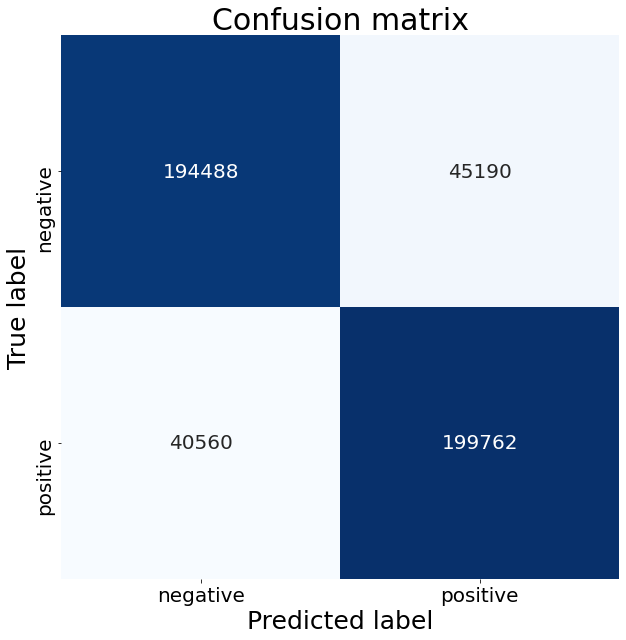

In [29]:
# confusion matrix
conf_mat = pd.DataFrame(confusion_matrix(y_test, preds))
conf_mat.index = ['negative','positive']
conf_mat.columns = ['negative','positive']

plt.figure(figsize = (10,10))
plt.title('Confusion matrix', size = 30)
sns.heatmap(conf_mat, annot = True,cmap='Blues', fmt='g', annot_kws={"fontsize":20}, cbar = False)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('Predicted label', size = 25)
plt.ylabel('True label', size = 25)
plt.show()

# Conclusions
As we can see our model (Linear SVC) achieved 82% accuracy, the attempts to increase accuracy using neural networks were unsuccessful. The accuracy was similar for both positive and negative tweets. 